# The Notebook is for pre-processing Mesogeos datacube to extract Portugal only.
## Datacube Source: https://github.com/Orion-AI-Lab/mesogeos/tree/main
## Portugal Shapefile Source: https://geodata.lib.utexas.edu/catalog/stanford-tq087tk3612
## Created by Aser Atawya for wildfire clustering project as part of Beculer Lab at University of Lausanne




# Imports and Installing dependencies (dependencies list is not minimal)


In [ ]:
!pip install zarr
!pip install sklearn-som
!pip install minisom
!pip install rasterio
!pip install rioxarray
!pip install geojson
!pip install netCDF4

In [14]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import MinMaxScaler, scale
from minisom import MiniSom
from sklearn_som.som import SOM
from sklearn import datasets
import numpy as np
from osgeo import gdal
import rasterio as rio
import geopandas
import rasterio.features
import rioxarray
import geojson
import pandas as pd
from sklearn.cluster import KMeans
#import netCDF4 as nc
import scipy.stats as stats
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from shapely.geometry import mapping
from shapely.ops import cascaded_union
gdal.SetConfigOption('SHAPE_RESTORE_SHX', 'YES')

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Accessing Data

In [17]:
ds = xr.open_zarr('/content/drive/MyDrive/mesogeos/mesogeos_cube.zarr/', decode_coords=all)

In [18]:
ds

<xarray.Dataset>
Dimensions:               (y: 1752, x: 4714, time: 6026)
Coordinates:
  * time                  (time) datetime64[ns] 2006-04-01 ... 2022-09-29
  * x                     (x) float64 -10.72 -10.71 -10.7 ... 36.72 36.73 36.74
  * y                     (y) float64 47.7 47.69 47.68 ... 30.09 30.08 30.07
Data variables: (12/30)
    aspect                (y, x) float32 dask.array<chunksize=(1752, 4714), meta=np.ndarray>
    burned_areas          (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    curvature             (y, x) float32 dask.array<chunksize=(1752, 4714), meta=np.ndarray>
    d2m                   (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    dem                   (y, x) float32 dask.array<chunksize=(1752, 4714), meta=np.ndarray>
    ignition_points       (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    ...                    ...
    spatial_ref           int64 ...
    ssrd                  (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    t2m                   (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    tp                    (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    wind_direction        (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    wind_speed            (time, y, x) float32 dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>

In [105]:
# slice a rectangle including Portugal from original dataset to speeden masking
# Those points represent the eastmost, westmost, northmost, and southmost points in Portugal mainland
ds_portugal = ds.sel(x=slice(-9.50,-6.20), y=slice( 42.16, 36.96))

In [112]:
ds_portugal

<xarray.Dataset>
Dimensions:               (y: 516, x: 327, time: 6026)
Coordinates:
    spatial_ref           int64 0
  * time                  (time) datetime64[ns] 2006-04-01 ... 2022-09-29
  * x                     (x) float64 -9.491 -9.481 -9.471 ... -6.218 -6.208
  * y                     (y) float64 42.15 42.14 42.13 ... 36.99 36.98 36.97
Data variables: (12/29)
    aspect                (y, x) float32 dask.array<chunksize=(516, 327), meta=np.ndarray>
    burned_areas          (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>
    curvature             (y, x) float32 dask.array<chunksize=(516, 327), meta=np.ndarray>
    d2m                   (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>
    dem                   (y, x) float32 dask.array<chunksize=(516, 327), meta=np.ndarray>
    ignition_points       (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>
    ...                    ...
    sp                    (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>
    ssrd                  (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>
    t2m                   (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>
    tp                    (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>
    wind_direction        (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>
    wind_speed            (time, y, x) float32 dask.array<chunksize=(1, 516, 327), meta=np.ndarray>

In [15]:
portugal = geopandas.read_file('/content/drive/MyDrive/data/tq087tk3612.shp', crs="epsg:4326")

In [132]:
portugal

,id_0,iso,name_engli,name_iso,name_fao,name_local,name_obsol,name_varia,name_nonla,name_frenc,...,caricom,eu,can,acp,landlocked,aosis,sids,islands,ldc,geometry
0,182.0,PRT,Portugal,PORTUGAL,Portugal,Portugal,NaN,Azores|Madeira,NaN,Portugal,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-16.05835 30.03020, -16.05837 ..."


In [133]:
ds_portugal.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
ds_portugal.rio.write_crs("epsg:4326", inplace=True)

clipped = ds_portugal.rio.clip(portugal.geometry.apply(mapping), portugal.crs, drop=True, from_disk =True)

In [134]:
np.count_nonzero(np.isnan(clipped['roads_distance'].values))
# This is the number of 1*1 km squares there were filtered out and converted to NaN

76456

In [135]:
np.count_nonzero(~np.isnan(clipped['roads_distance'].values))
# This is the number of remaining 1*1 km squares

91949

### While we have 76456 squares that are Nans, we can't remove them because the datacube is structred as X,Y coordinates that represent 2D array i.e. rectangle.

# Visualizations of the clipped datacube

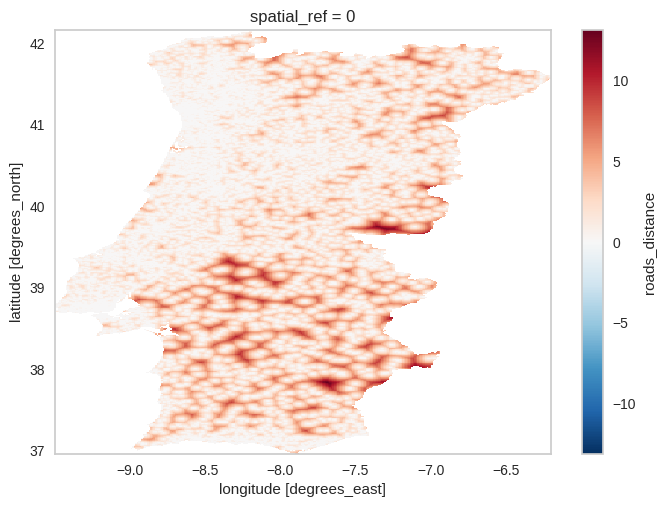

In [111]:
clipped.roads_distance.plot()

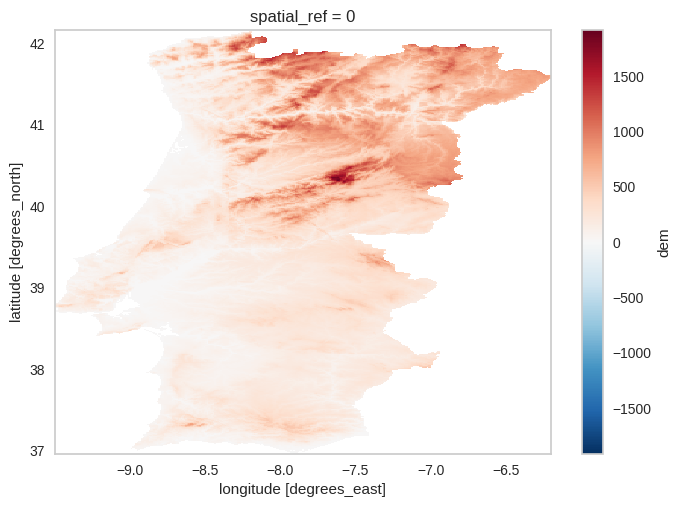

In [110]:
clipped.dem.plot()

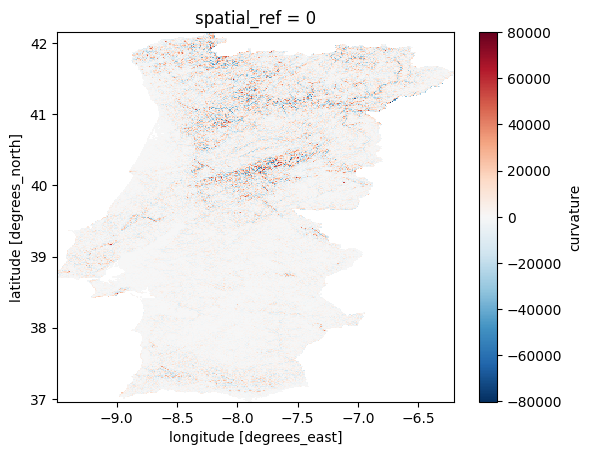

In [ ]:
clipped.curvature.plot()

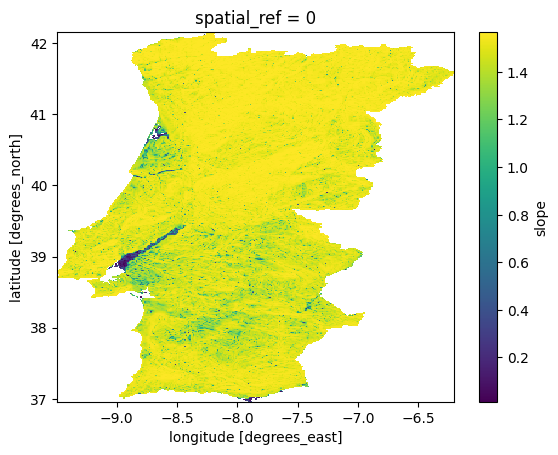

In [ ]:
clipped.slope.plot()

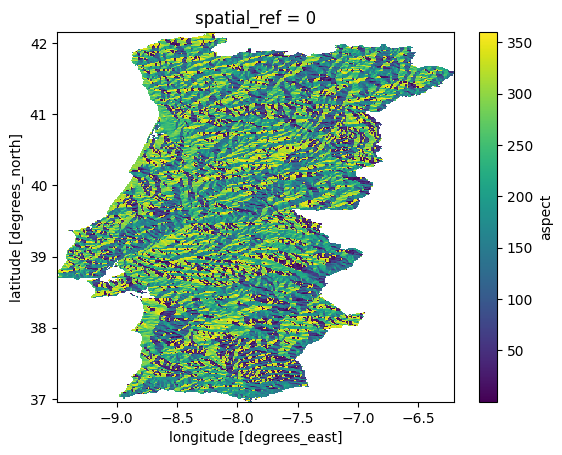

In [ ]:
clipped.aspect.plot()

# Saving the files to the cloud
## Saves year by year to avoid Collab Crashing

In [172]:
portugal_2006_2007 = clipped.sel(time=slice('2006-04-01','2007-03-31'))

In [173]:
portugal_2006_2007

<xarray.Dataset>
Dimensions:               (x: 327, y: 515, time: 365)
Coordinates:
  * x                     (x) float64 -9.491 -9.481 -9.471 ... -6.218 -6.208
  * y                     (y) float64 42.14 42.13 42.12 ... 36.99 36.98 36.97
    spatial_ref           int64 0
  * time                  (time) datetime64[ns] 2006-04-01 ... 2007-03-31
Data variables: (12/29)
    aspect                (y, x) float32 dask.array<chunksize=(515, 327), meta=np.ndarray>
    burned_areas          (time, y, x) float32 dask.array<chunksize=(1, 515, 327), meta=np.ndarray>
    curvature             (y, x) float32 dask.array<chunksize=(515, 327), meta=np.ndarray>
    d2m                   (time, y, x) float32 dask.array<chunksize=(1, 515, 327), meta=np.ndarray>
    dem                   (y, x) float32 dask.array<chunksize=(515, 327), meta=np.ndarray>
    ignition_points       (time, y, x) float32 dask.array<chunksize=(1, 515, 327), meta=np.ndarray>
    ...                    ...
    sp                    (time, y, x) float32 dask.array<chunksize=(1, 515, 327), meta=np.ndarray>
    ssrd                  (time, y, x) float32 dask.array<chunksize=(1, 515, 327), meta=np.ndarray>
    t2m                   (time, y, x) float32 dask.array<chunksize=(1, 515, 327), meta=np.ndarray>
    tp                    (time, y, x) float32 dask.array<chunksize=(1, 515, 327), meta=np.ndarray>
    wind_direction        (time, y, x) float32 dask.array<chunksize=(1, 515, 327), meta=np.ndarray>
    wind_speed            (time, y, x) float32 dask.array<chunksize=(1, 515, 327), meta=np.ndarray>

In [174]:
#dropping the grid_mapping attribute to avoid the error "failed to prevent overwriting existing key grid_mapping in attrs"
vars_list = list(portugal_2006_2007.data_vars)
for var in vars_list:
  del portugal_2006_2007[var].attrs['grid_mapping']

In [ ]:
portugal_2006_2007.to_netcdf('/content/drive/MyDrive/data/years/2006_2007.nc')